# Description

## Packages

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, FalsePositives, \
#                                     TruePositives, TrueNegatives, FalseNegatives, AUC, Metric
sys.path.insert(1, "/users/rserage/Zoon0PredV/bin/")
from metrics_helper import MatthewsCorrelationCoefficient
from model_definition import Zoon0Pred_model
tf.get_logger().setLevel('ERROR')

## Set random seed

Still having some issues... seeding is not applied somehow

In [2]:
# seed(20192020)
# set_seed(20192020)

## Activate GPU devices

In [3]:
# Set GPU usage and memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Tensorflow ({tf.__version__}) recognises {len(physical_devices)} GPU(s)\nEnabling GPU memory growth")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, enable=True) 

Tensorflow (2.6.0) recognises 1 GPU(s)
Enabling GPU memory growth


### Activate distribute strategy to distribute GPU computations across available GPUs

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

## Chaos game representation

This is an example of the CGR images which the model will be training on.

<!-- ![CGR represention of virus protein sequences](./plots.png) -->
<img src=./plots.png width=600 height=500>

## Data loading

### Using keras image data generator

In [16]:
# directories = [os.path.join('../../pipeline-output/ZoonosisData', dtry) for dtry in ['train', 'test']]
directories = [os.path.join('/scratch2/users/rserage/ZoonosisFull/', dtry) for dtry in ['train', 'test']]

BATCH_SIZE = 1024

TARGET_SIZE = (128,128)

test_data_generator = ImageDataGenerator(rescale=1./255) # Specifically for test data

train_val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) # For training and validation split

train_data_iterator = train_val_data_generator.flow_from_directory(directories[0], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary',
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603,
                                              subset='training') # Specifies subset, ignored in test

validation_data_iterator = train_val_data_generator.flow_from_directory(directories[0], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary',
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603,
                                              subset='validation')

test_data_iterator = test_data_generator.flow_from_directory(directories[1], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary', shuffle=False,
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603
                                                            )

Found 243794 images belonging to 2 classes.
Found 60947 images belonging to 2 classes.
Found 114206 images belonging to 2 classes.


In [17]:
TRAIN_STEPS = train_data_iterator.n//BATCH_SIZE
VALIDATION_STEPS = validation_data_iterator.n//BATCH_SIZE

In [18]:
TRAIN_STEPS

238

In [19]:
VALIDATION_STEPS

59

In [20]:
keras.backend.clear_session()

## Model building, compilation and training

#### Callback functions for model training

In [14]:
logs = CSVLogger('logs.csv')

model_checkpoint_callback = ModelCheckpoint(
    filepath='check.ckpt',
    save_weights_only=True,
    monitor='MCC',
    mode='max',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_AUC',
    factor=0.2, patience=3,
    min_lr=0.001
)

### Model training

In [21]:
model = Zoon0Pred_model(mirrored_strategy)

history = model.fit(
    train_data_iterator, 
    steps_per_epoch=TRAIN_STEPS,
    validation_data=validation_data_iterator, 
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    verbose=1,
    # use_multiprocessing=True,
    shuffle=True,
#     class_weight={0:4.11808002, 1:0.56909742},
    callbacks=[
        logs,
        model_checkpoint_callback,
        # reduce_lr
        ])

Epoch 1/15
238/238 [==============================] - 568s 2s/step - loss: 11.9465 - binary_accuracy: 0.8544 - FP: 27507.0000 - TP: 205292.0000 - TN: 2129.0000 - FN: 7842.0000 - MCC: 0.0578 - AUC: 0.5362 - val_loss: 0.4191 - val_binary_accuracy: 0.8779 - val_FP: 7378.0000 - val_TP: 53038.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_MCC: 0.0000e+00 - val_AUC: 0.4982
Epoch 2/15
238/238 [==============================] - 554s 2s/step - loss: 0.3759 - binary_accuracy: 0.8810 - FP: 28064.0000 - TP: 212309.0000 - TN: 1574.0000 - FN: 823.0000 - MCC: 0.1631 - AUC: 0.6534 - val_loss: 0.9297 - val_binary_accuracy: 0.1223 - val_FP: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 7386.0000 - val_FN: 53030.0000 - val_MCC: 0.0000e+00 - val_AUC: 0.4875
Epoch 3/15
238/238 [==============================] - 551s 2s/step - loss: 0.2612 - binary_accuracy: 0.8971 - FP: 17713.0000 - TP: 205852.0000 - TN: 11937.0000 - FN: 7268.0000 - MCC: 0.4470 - AUC: 0.8741 - val_loss: 0.6579 - val_binary_accuracy: 0.15

UnknownError: 2 root error(s) found.
  (0) Unknown:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fe78c6a31a8>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.6/dist-packages/keras/engine/data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.6/dist-packages/keras/engine/data_adapter.py", line 948, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 3031, in open
    "cannot identify image file %r" % (filename if filename else fp)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fe78c6a31a8>


	 [[{{node PyFunc}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[ReadVariableOp_4/_90]]
  (1) Unknown:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fe78c6a31a8>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.6/dist-packages/keras/engine/data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.6/dist-packages/keras/engine/data_adapter.py", line 948, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 3031, in open
    "cannot identify image file %r" % (filename if filename else fp)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fe78c6a31a8>


	 [[{{node PyFunc}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_9960]

Function call stack:
test_function -> test_function


## Save best model

Useful in the script but not necessary in this the notebook context

In [22]:
model.load_weights('check.ckpt')
save_model(model, 'model')

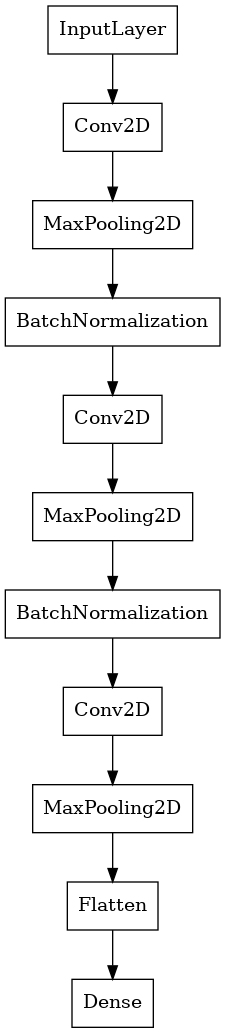

In [24]:
plot_model(model, "Zoonopred.png", show_layer_names=False)

## Model evaluation

In [14]:
model.evaluate(test_data_iterator, return_dict=True, steps=321)

NameError: name 'np' is not defined

In [25]:
history.params

NameError: name 'history' is not defined

In [23]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'Recall', 'Precision', 'FP', 'TP', 'TN', 'FN', 'MCC', 'AUC', 'val_loss', 'val_binary_accuracy', 'val_Recall', 'val_Precision', 'val_FP', 'val_TP', 'val_TN', 'val_FN', 'val_MCC', 'val_AUC', 'lr'])

### Model training with cross validation

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.utils import class_weight
# import numpy as np

In [9]:
# os.getcwd()

In [10]:
# # os.chdir('/home/campbell/Documents/Rudolph/data/')
# dataset_directory = '/home/campbell/Documents/Rudolph/data/MetazoaZoonosisData/train'
# data_subdirectories = ['human-false', 'human-true']

In [11]:
# X, y = createImageData(data_dir=dataset_directory, subdir=data_subdirectories)

# print(X.shape)
# print(y.shape)

In [12]:
# seed = 960505
# def balanced_flow_from_directory(flow_from_directory):
#     rus = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
# #     X_sample, y_sample = rus.fit_resample(X, y)
#     for x, y in flow_from_directory.get(2):
#          yield rus.fit_resample(x, y)

# train_data = balanced_flow_from_directory(train_data_iterator)

In [16]:
# model_checkpoint = 'check.ckpt'
# # logs = 'logs.csv'
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=model_checkpoint,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# seed = 960505

# # Evaluating a model with random oversampling and undersampling
# ## Resample data
# # Sampling strategy resamples dataset to a 2:1 ratio of the majority class
# # rus = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
# # X_sample, y_sample = rus.fit_resample(X, y)

# # print(X_sample.shape)
# # print(y_sample.shape)

# ## Define cross validator
# cv = RepeatedStratifiedKFold(n_splits=5, random_state=seed)

# ## Define model
# model = ConvNetModel()

# # parameters passed to fit method
# fit_params = {'shuffle':True, 'epochs':100,
#               'verbose':0, 'class_weight':class_weights,
#               'callbacks':[CSVLogger('logs.csv'), model_checkpoint_callback]}

# # Train model with 5-fold cross validation
# scores = cross_val_score(model,
#                          train_data_iterator,
#                          scoring='f1',
#                          cv=cv, #n_jobs=1,
#                          fit_params=fit_params)

# score = np.mean(scores)
# print('F1 Score: %.3f' % score)

In [ ]:
# import cv2

# def img_proc(image):
#     img_mtx = cv2.subtract(255, cv2.imread(image, cv2.IMREAD_GRAYSCALE))
#     save_as = os.path.join(path, image)
#     cv2.imwrite(save_as, img_mtx)

# from concurrent.futures import ThreadPoolExecutor

# images_list = []

# for directory in dirs:
#     dir_items = os.listdir(directory)
#     dir_items_full_name = [os.path.join(directory, item) for item in dir_items]
#     images_list.append(dir_items_full_name)

# with ThreadPoolExecutor() as executor:
#     list(tqdm(executor.map(img_proc, images_list), total=len(images_list)))